# Algorytmy macierzowe

## Mnożenie macierzy IGA i FEM

In [25]:
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.sparse
import time
import os

### Konwersja macierzy n x n wygenerowanej w Octave na macierz numpy nq x nq.    
Wynikowa macierz, to macierz Octave powtórzona q razy w poziomie i pionie.

In [2]:
def input_matrix(octave_matrix, n, m, q=1):
    result = np.zeros((n*q, m*q), dtype=np.double)
    
    for elem in octave_matrix:
        m = re.match(r"\s*\((\d+), (\d+)\) -> (\d+\.\d+)\s*", elem)
        if m is not None: # dla macierzy 256x256 dostaje m = None...
            x, y, value = m.groups()
        elif len(elem) > 0:
            coord, value = elem.strip().split(' -> ')
            value = float(value)
            x, y = coord.split(',')
            x, y = x[1:], y.strip()[:-1]
        else:
            continue
        
        for i in range(q):
            for j in range(q):
                result[i*n + int(x) - 1, j*n + int(y) - 1] = float(value)
        
    return result

In [3]:
def load_octave_matrix(filename):
    with open(filename, "r") as file:
        return file.readlines()

In [4]:
data_dir = "../output"

def resolve_path(matrix_type, width, height = None):
    if height is None: height = width
    path = f"{data_dir}/{matrix_type}-{width}x{height}.txt"
    if os.path.isfile(path): return path
    else: raise FileNotFoundError(f"Matrix file {path} not found")

resolve_matrix = lambda matrix_type, n, m, q = 1: input_matrix(
    load_octave_matrix(resolve_path(matrix_type, n, m)), n, m, q
)

In [5]:
def timeit(times = 1, loops = 2):
    def timed_func(func):
        def wrapper(*args):
            tries_time = 0
            for n_try in range(times):
                loops_time = 0
                for loop in range(loops):
                    t_start = time.time()
                    func(*args)
                    loops_time += time.time() - t_start
                tries_time += loops_time / loops
            return tries_time / times
        return wrapper
    return timed_func

### Sześć algorytmów mnożenia macierzy w zależności od kolejności pętli i, j oraz p.    
A - macierz wejściowa n x m    
B - macierz wejściowa m x k   
C - macierz wynikowa n x k

In [6]:
def matrix_mul_ijp(A, B, C, n, m, k):
    for i in range(n):
        for j in range(m):
            for p in range(k):
                 C[i,j] += A[i,p]*B[p,j]
                    
def matrix_mul_ipj(A, B, C, n, m, k):
    for i in range(n):
        for p in range(k):
            for j in range(m):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_jip(A, B, C, n, m, k):
    for j in range(m):
        for i in range(n):
            for p in range(k):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_jpi(A, B, C, n, m, k):
    for j in range(m):
        for p in range(k):
            for i in range(n):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_pij(A, B, C, n, m, k):
    for p in range(k):
        for i in range(n):
            for j in range(m):
                 C[i,j] += A[i,p]*B[p,j]

def matrix_mul_pji(A, B, C, n, m, k):
    for p in range(k):
        for j in range(m):
            for i in range(n):
                 C[i,j] += A[i,p]*B[p,j]

mmul = {
    "warmuprun": matrix_mul_ijp,
    "ijp": matrix_mul_ijp,
    "ipj": matrix_mul_ipj,
    "jip": matrix_mul_jip,
    "jpi": matrix_mul_jpi,
    "pij": matrix_mul_pij,
    "pji": matrix_mul_pji
}

### Macierze wejściowe

In [7]:
SIZE = 256
n = SIZE   # liczba wierszy macierzy A
m = SIZE   # liczba kolumn macierzy A / liczba wierszy macierzy B
k = SIZE   # liczba kolumn macierzy B
q = 1      # czynnik skalujący macierze
N_n = n * q
N_m = m * q
N_k = k * q

In [8]:
A = resolve_matrix("iga", n, m, q)
B = resolve_matrix("fem", m, k, q)
print("Wymiary macierzy A:", A.shape)
print("Wymiary macierzy B:", B.shape)

Wymiary macierzy A: (256, 256)
Wymiary macierzy B: (256, 256)


### Sprawdzanie najszybszego algorytmu

In [9]:
stats = {}

min_loop_time = None
min_mul_type = "ijp"
mmul_optimal = mmul[min_mul_type]

for mul_type, mul_fun in mmul.items():
    print(f"{mul_type}:")
    C = np.zeros((N_n, N_k))
    loop_time = %timeit -n 1 -r 1 -o mul_fun(A, B, C, N_n, N_m, N_k)
    if mul_type == "warmaprun": continue
    stats[mul_type] = loop_time.average
    if min_loop_time is None or min_loop_time > loop_time.average:
        min_loop_time = loop_time.average
        min_mul_type = mul_type
        mmul_optimal = mul_fun

print(f"\nNajszybsza konfiguracja: {min_mul_type}")

warmuprun:
10.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
ijp:
10.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
ipj:
10.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
jip:
10.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
jpi:
10.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
pij:
10.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
pji:
10.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Najszybsza konfiguracja: ijp


In [17]:
# opcjonalnie można zatrudnić pandas, wtedy tabelka automatycznie powinna
# być elegancka
from IPython.display import Markdown as md
table = """
| Kolejność pętli | Czas [s] |
|:---------------:|:--------:|
"""
for loop_order, loop_time in stats.items():
    table += f"|{loop_order}|{loop_time:>.6}|\n"

md(table)


| Kolejność pętli | Czas [s] |
|:---------------:|:--------:|
|warmuprun|10.1764|
|ijp|10.0626|
|ipj|10.0638|
|jip|10.1295|
|jpi|10.2575|
|pij|10.2887|
|pji|10.1681|


### Arbitralny wybór optymalnego algorytmu 

Jeżeli ma zostać wykorzystany algorytm wyznaczony obliczeniowo (w komórce powyżej), nie wykonywać komórki poniżej.

In [18]:
mmul_optimal = mmul["ijp"]

### Sprawdzanie niezerowych miejsc macierzy A, B i C

In [19]:
C = np.zeros((N_n, N_k))
%timeit -n 1 -r 1 mmul_optimal(A, B, C, N_n, N_m, N_k)

10.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


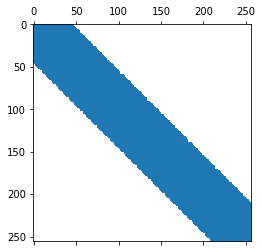

In [20]:
plt.spy(scipy.sparse.csr_matrix(A))
plt.show()

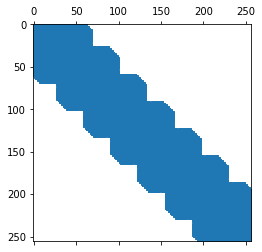

In [21]:
plt.spy(scipy.sparse.csr_matrix(B))
plt.show()

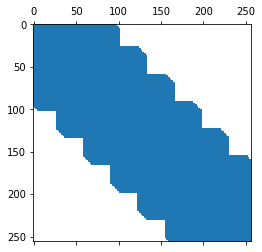

In [22]:
plt.spy(scipy.sparse.csr_matrix(C))
plt.show()

### Mnożenie blokowe macierzy przyjmując wielkość bloków: block_size x block_size.

matrix_mul_fun to jedna z wybranych funkcji mnożenia macierzy zaimplementowanych wyżej

In [23]:
def matrix_block_mul(A, B, C, m, n, k, block_size, matrix_mul_fun):
    for j in range(0, m, block_size):
        j_block = min(m - j, block_size)
        for i in range(0, n, block_size):
            i_block = min(n - i, block_size)
            for p in range(0, k, block_size):
                p_block = min(k - p, block_size)
                matrix_mul_fun(A[i:i + i_block, p:p + p_block], 
                               B[p:p + p_block, j:j + j_block], 
                               C[i:i + i_block, j:j + j_block], 
                               i_block, j_block, p_block)

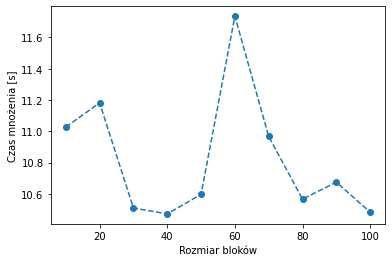

In [27]:
blocks = []
mul_time = []
multiplier = 10
runs = 1

for i in range(1, 11):
    C = np.zeros((N_n, N_k))
    t0 = time.time()
    for j in range(runs):
        matrix_block_mul(A, B, C, N_n, N_m, N_k, multiplier*i, mmul_optimal)
    blocks.append(multiplier*i)
    mul_time.append((time.time() - t0) / runs)
    
plt.plot(blocks, mul_time, linestyle='--')
plt.scatter(blocks, mul_time)
plt.xlabel("Rozmiar bloków")
plt.ylabel("Czas mnożenia [s]")
plt.show()